# Benchmark Analysis

In [1]:
%cd ..

/home/rotaldf/projects/msc-thesis-code/activesecuritympc


/home/rotaldf/projects/msc-thesis-code/python_zkp_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
import numpy as np
import os

In [3]:
if not os.path.exists("figures"):
    os.makedirs("figures")

In [4]:
passive_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_passive_{i}_parties.csv"
    passive_readings.append(pd.read_csv(file))
passive_readings = pd.concat(passive_readings)
passive_readings['total_communication_cost'] = passive_readings['total_bytes_sent'] + passive_readings['total_bytes_recv']
passive_readings = passive_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

groth16_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_active_groth16_{i}_parties.csv"
    groth16_readings.append(pd.read_csv(file))
groth16_readings = pd.concat(groth16_readings)
groth16_readings['total_communication_cost'] = groth16_readings['total_bytes_sent'] + groth16_readings['total_bytes_recv']
groth16_readings['total_verification_time'] /= groth16_readings['parties']
groth16_readings = groth16_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

bulletproofs_readings = []
for i in range(3, 26):
    file = f"benchmarks/sum_active_bulletproofs_{i}_parties.csv"
    bulletproofs_readings.append(pd.read_csv(file))
bulletproofs_readings = pd.concat(bulletproofs_readings)
bulletproofs_readings['total_communication_cost'] = bulletproofs_readings['total_bytes_sent'] + bulletproofs_readings['total_bytes_recv']
bulletproofs_readings['total_verification_time'] /= bulletproofs_readings['parties']
bulletproofs_readings = bulletproofs_readings.drop(columns=['total_bytes_sent', 'total_bytes_recv'])

parties = range(3,26)

In [5]:
def produce_plot(fig, ax, data, metric_dict, name, metric='runtime', id=0, semilog=False, marker='o', color='black'):
    # Calculate mean, median and stdiv for each id over ensemble
    grouped_data = data.groupby(['parties', 'id'])
    mean_data = grouped_data.mean()
    median_data = grouped_data.median()
    std_data = grouped_data.std()
    
    # Drop ensemble column
    mean_data = mean_data.drop(columns='ensemble')
    median_data = median_data.drop(columns='ensemble')
    std_data = std_data.drop(columns='ensemble')
    
    # Get data specifically for party 0
    median_data_0 = median_data[median_data.index.get_level_values('id') == id]
    mean_data_0 = mean_data[mean_data.index.get_level_values('id') == id]
    std_data_0 = std_data[std_data.index.get_level_values('id') == id]
    
    # Produce plot for a given metric
    parties = median_data_0.index.get_level_values('parties')
    data = median_data_0[metric]
    std_dev = std_data_0[metric]

    ax.errorbar(parties, data, yerr=std_dev, marker=marker, linestyle='-', linewidth=1, capsize=4, color=color, label=name)
    if semilog:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale
        # Add major grid lines for better readability
        ax.yaxis.grid(True, linestyle='-', alpha=0.7)
        # Add minor grid lines as dotted lines
        ax.minorticks_on()
        ax.yaxis.grid(which='minor', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(AutoLocator())
    ax.set_xlim(3-0.5, max(parties)+0.5)
    ax.set_xlabel('parties', fontsize=12)
    ax.set_ylabel(metric_dict[metric], fontsize=12)
    if name:
        ax.legend(loc='upper left', fontsize='small')
    ax.tick_params(axis='both', which='major', labelsize=10)

    
    return fig, ax, data

In [6]:
names = {
    "total_zkp_constraints": "constraints",
    "total_zkp_compile_time": "time (sec)",
    "total_proof_size": "size (bytes)",
    "total_proving_time": "time (sec)",
    "total_crs_generation_time": "time (sec)",
    "total_crs_len": "size (bytes)",
    "total_verification_time": "time (sec)",
    "cache_size": "size (bytes)",
    "runtime": "time (sec)",
    "total_runtime": "time (sec)",
    "total_communication_cost": "data (bytes)",
    "setup_time": "time (sec)",
    "engagement_time": "time (sec)",
    "emulation_time": "time (sec)",
}

## Analysis

We start with the basics, i.e. overall runtime and communication cost for passive, active (groth16) and active (bulletproofs)

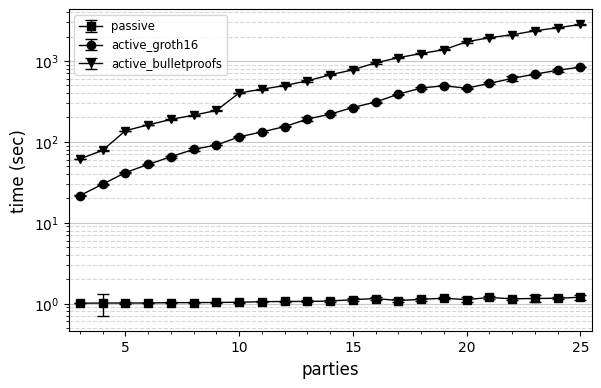

In [7]:
# Total runtime
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "passive", "runtime", marker='s', semilog=True)
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_runtime", marker='o')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_runtime", marker='v')
fig.savefig('figures/total_runtime.pdf')

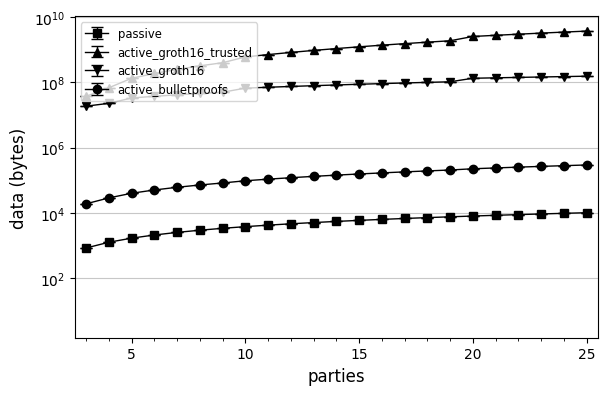

In [8]:
# Total communication cost
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, passive_readings, names, "passive", "total_communication_cost", marker='s', semilog=True)
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16_trusted", "total_communication_cost", marker='^')
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "active_groth16", "total_communication_cost", id=1, marker='v')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "active_bulletproofs", "total_communication_cost", marker='o')
fig.savefig('figures/total_communication_cost.pdf')

Clearly active security is far more expensive than passive security
* regarding the runtime, it at least 1 and upwards of 2 orders of magnitude slower (groth < bulletproofs differ by half order of magnitude), and follows an exponential trend.
* regarding communication cost, active security using bulletproofs is a bit over 1 order of magnitude more expensive and follows a linear trend. Active security using groth16 is over 4 orders of magnitude more expensive when it is not the trusted party, and becomes increasingly more expensive when it is.

### Breakdown of runtime over the different active security compiler phases

To understand why active security with bulletproofs requires more computation time, let's break down the runtime analysis into its parts

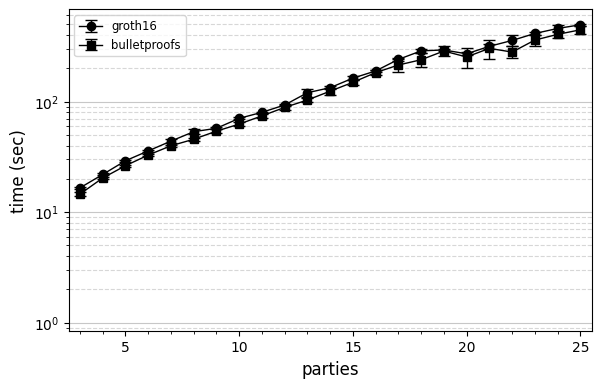

In [9]:
# Setup time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "setup_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "setup_time", marker='s')
fig.savefig('figures/active_setup_time.pdf')

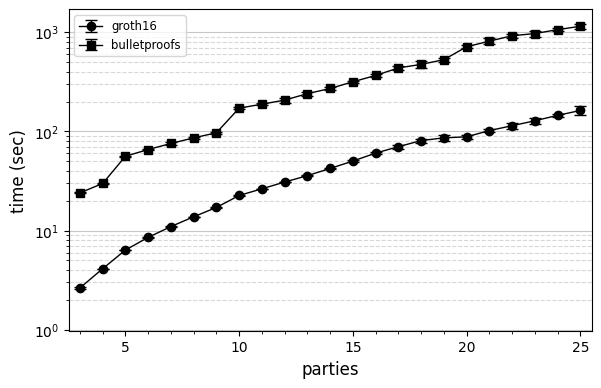

In [10]:
# Engagement time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "engagement_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "engagement_time", marker='s')
fig.savefig('figures/active_engagement_time.pdf')

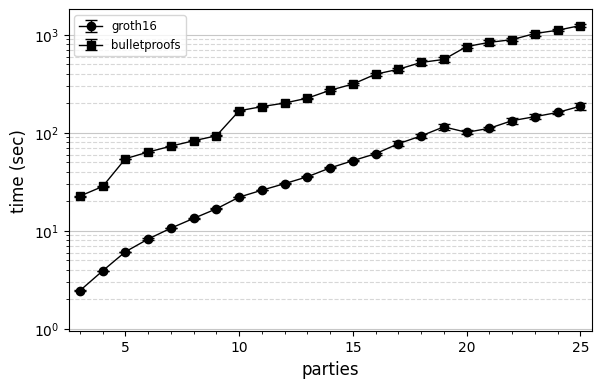

In [11]:
# Emulation time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "emulation_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "emulation_time", marker='s')
fig.savefig('figures/active_emulation_time.pdf')

For the setup phase, it appears that both groth16 and bulletproofs are quite similar, but groth16 is a bit slower due to the trusted setup. Moreover, engagement and emulation are both similar where active security with bulletproofs is about 1 order of magnitude slower than with groth16.

### Breakdown of setup phase

We measure the runtime and size of the components in setup phase, more specifically the ZKP compilation runtime and number of constraints, and the CRS generation runtime and size:

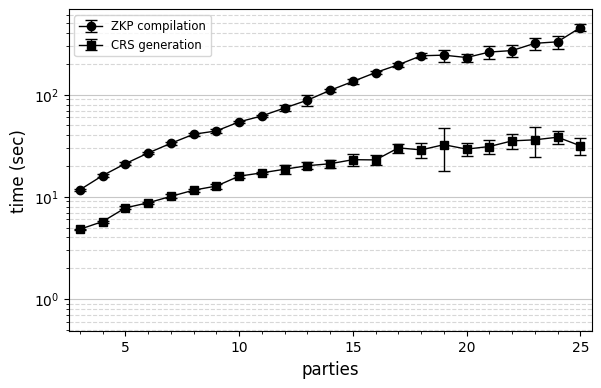

In [12]:
# Total CRS generation and ZKP compilation time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "ZKP compilation", "total_zkp_compile_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "CRS generation", "total_crs_generation_time", marker='s')
fig.savefig('figures/zkp_comp_crs_gen.pdf')

We see that ZKP compilation time has an exponential trend, while CRS generation time seems to follow more of a linear trend

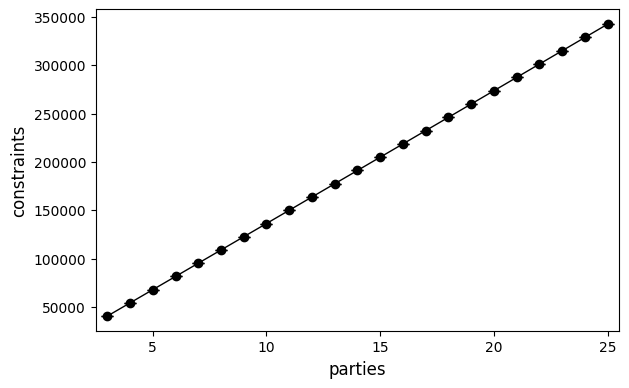

In [13]:
# Total ZKP constraints
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "", "total_zkp_constraints", marker='o', semilog=False)
fig.savefig('figures/constraints_count.pdf')

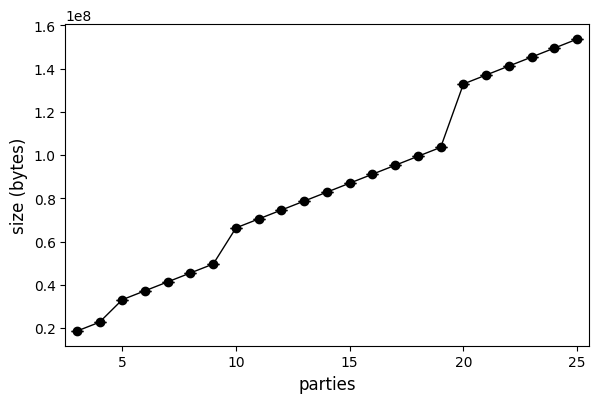

In [14]:
# Total CRS length
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "", "total_crs_len", marker='o', semilog=False)
fig.savefig('figures/crs_length.pdf')

ZKP constraints are clearly linear with party size, while CRS length is linear but has steep increments at m=5, m=9 and m=20

### Breakdown of engagement and emulation phase

Both engagement and emulation essentially are limited by the ZKP proofs and verifications.  We inspect the components as follows

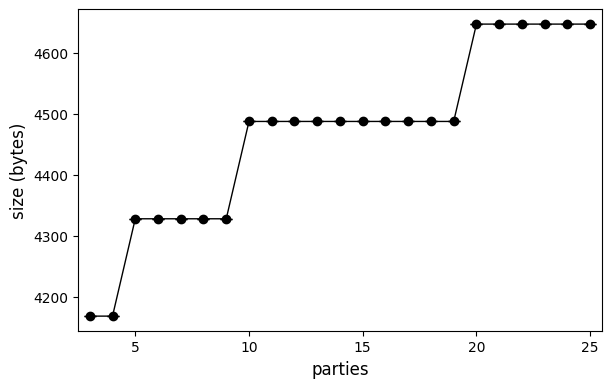

In [15]:
# Total CRS length and ZKP constraints
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
# fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proof_size", marker='o', semilog=False)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_proof_size", marker='o')
fig.savefig('figures/active_bulletproofs_proof_size.pdf')

Groth16 always produces constant size proofs, whereas Bulletproofs are sublinear in the size of number of constraints

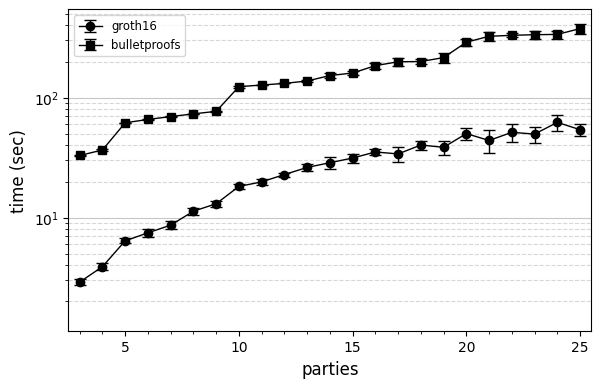

In [16]:
# Total proving time
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_proving_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_proving_time", marker='s')
fig.savefig('figures/active_proving_time.pdf')

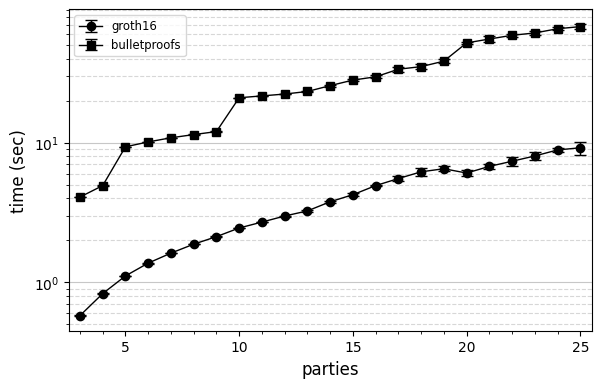

In [17]:
# Total verification time per party
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "total_verification_time", marker='o', semilog=True)
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "total_verification_time", marker='s')
fig.savefig('figures/active_verification_time.pdf')

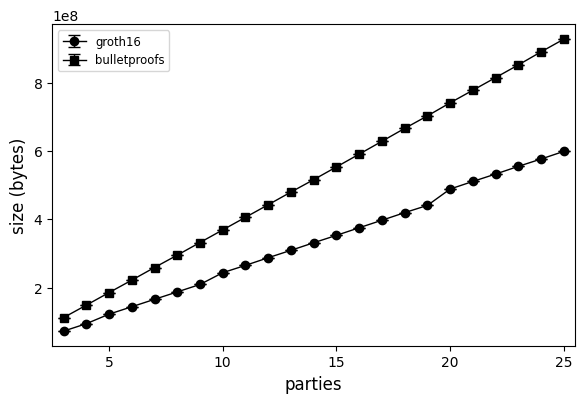

In [18]:
# Cache (memory) size
fig, ax = plt.subplots(figsize=(6.75, 2.0858647120308955*2))
fig, ax, _ = produce_plot(fig, ax, groth16_readings, names, "groth16", "cache_size", marker='o')
fig, ax, _ = produce_plot(fig, ax, bulletproofs_readings, names, "bulletproofs", "cache_size", marker='s')
fig.savefig('figures/active_cache.pdf')

### Relative runtimes

Lastly we measure how all components compare against the overall runtime and communication cost to see which is the bottleneck.

Runtime contributions:
* Components percentage plot: total_zkp_compile_time, total_crs_generation_time, total_proving_time, total_verification_time, remainder
* Phases percentage plot: setup_time, engagement_time, emulation_time, remainder

for cache it is kind of useless due to serialization of components, and for communication we only compare proof size to crs size (which depend on each other), so also not interesting.

#### Groth16

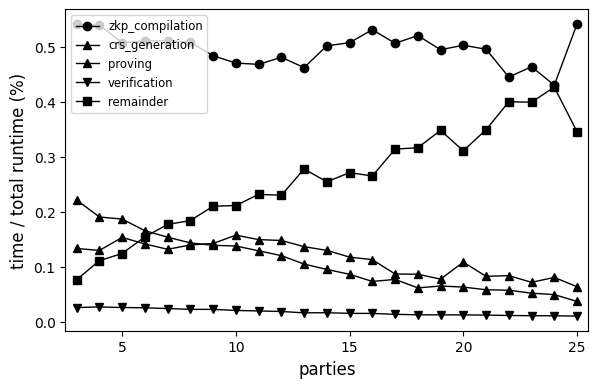

In [19]:
# For different components
_, _, runtime_data = produce_plot(fig, ax, groth16_readings, names, "", "total_runtime")
_, _, zkp_compile_time_data = produce_plot(fig, ax, groth16_readings, names, "", "total_zkp_compile_time")
_, _, crs_generation_time_data = produce_plot(fig, ax, groth16_readings, names, "", "total_crs_generation_time")
_, _, proving_time_data = produce_plot(fig, ax, groth16_readings, names, "", "total_proving_time")
_, _, verification_time_data = produce_plot(fig, ax, groth16_readings, names, "", "total_verification_time")

zkp_compile_time_percent = zkp_compile_time_data / runtime_data
crs_generation_time_percent = crs_generation_time_data / runtime_data
proving_time_percent = proving_time_data / runtime_data
verification_time_percent = verification_time_data / runtime_data
remainder_percent = 1 - (zkp_compile_time_percent + crs_generation_time_percent + proving_time_percent + verification_time_percent)

plt.figure(figsize=(6.75, 2.0858647120308955*2))
plt.plot(parties, zkp_compile_time_percent, linestyle="-", linewidth=1, color='black', marker="o", label="zkp_compilation")
plt.plot(parties, crs_generation_time_percent, linestyle="-", linewidth=1, color='black', marker="^", label="crs_generation")
plt.plot(parties, proving_time_percent, linestyle="-", linewidth=1, color='black', marker="^", label="proving")
plt.plot(parties, verification_time_percent, linestyle="-", linewidth=1, color='black', marker="v", label="verification")
plt.plot(parties, remainder_percent, linestyle="-", linewidth=1, color='black', marker="s", label="remainder")

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('time / total runtime (%)', fontsize=12)
plt.legend(loc='upper left', fontsize='small')

plt.savefig('figures/groth16_relative_component_times.pdf')

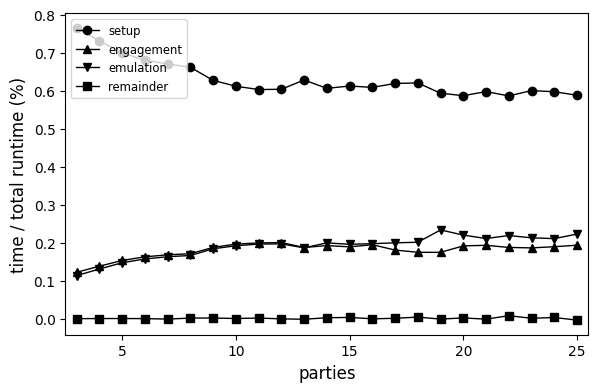

In [20]:
# For different phases
_, _, runtime_data = produce_plot(fig, ax, groth16_readings, names, "", "total_runtime")
_, _, setup_time_data = produce_plot(fig, ax, groth16_readings, names, "", "setup_time")
_, _, engagement_time_data = produce_plot(fig, ax, groth16_readings, names, "", "engagement_time")
_, _, emulation_time_data = produce_plot(fig, ax, groth16_readings, names, "", "emulation_time")

setup_time_percent = setup_time_data / runtime_data
engagement_time_percent = engagement_time_data / runtime_data
emulation_time_percent = emulation_time_data / runtime_data
remainder_percent = 1 - (setup_time_percent + engagement_time_percent + emulation_time_percent)

plt.figure(figsize=(6.75, 2.0858647120308955*2))
plt.plot(parties, setup_time_percent, linestyle="-", linewidth=1, color='black', marker="o", label="setup")
plt.plot(parties, engagement_time_percent, linestyle="-", linewidth=1, color='black', marker="^", label="engagement")
plt.plot(parties, emulation_time_percent, linestyle="-", linewidth=1, color='black', marker="v", label="emulation")
plt.plot(parties, remainder_percent, linestyle="-", linewidth=1, color='black', marker="s", label="remainder")

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('time / total runtime (%)', fontsize=12)
plt.legend(loc='upper left', fontsize='small')

plt.savefig('figures/groth16_relative_phases_times.pdf')

#### Bulletproofs

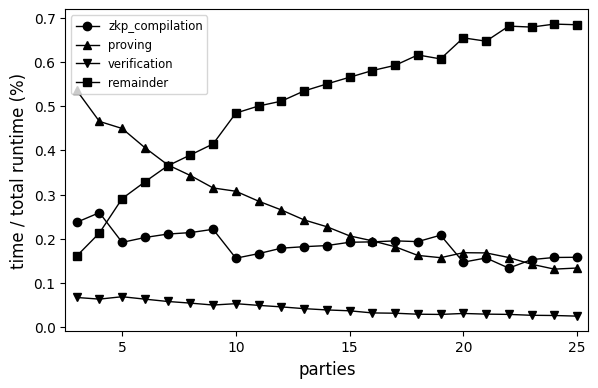

In [21]:
# For different components
_, _, runtime_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_runtime")
_, _, zkp_compile_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_zkp_compile_time")
_, _, proving_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_proving_time")
_, _, verification_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_verification_time")

zkp_compile_time_percent = zkp_compile_time_data / runtime_data
proving_time_percent = proving_time_data / runtime_data
verification_time_percent = verification_time_data / runtime_data
remainder_percent = 1 - (zkp_compile_time_percent + proving_time_percent + verification_time_percent)

plt.figure(figsize=(6.75, 2.0858647120308955*2))
plt.plot(parties, zkp_compile_time_percent, linestyle="-", linewidth=1, color='black', marker="o", label="zkp_compilation")
plt.plot(parties, proving_time_percent, linestyle="-", linewidth=1, color='black', marker="^", label="proving")
plt.plot(parties, verification_time_percent, linestyle="-", linewidth=1, color='black', marker="v", label="verification")
plt.plot(parties, remainder_percent, linestyle="-", linewidth=1, color='black', marker="s", label="remainder")

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('time / total runtime (%)', fontsize=12)
plt.legend(loc='upper left', fontsize='small')

plt.savefig('figures/bulletproofs_relative_component_times.pdf')

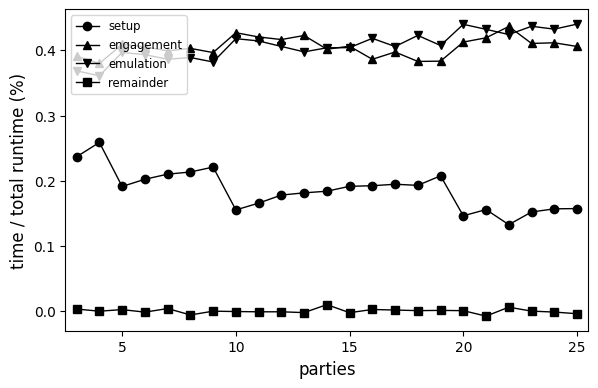

In [22]:
# For different phases
_, _, runtime_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "total_runtime")
_, _, setup_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "setup_time")
_, _, engagement_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "engagement_time")
_, _, emulation_time_data = produce_plot(fig, ax, bulletproofs_readings, names, "", "emulation_time")

setup_time_percent = setup_time_data / runtime_data
engagement_time_percent = engagement_time_data / runtime_data
emulation_time_percent = emulation_time_data / runtime_data
remainder_percent = 1 - (setup_time_percent + engagement_time_percent + emulation_time_percent)

plt.figure(figsize=(6.75, 2.0858647120308955*2))
plt.plot(parties, setup_time_percent, linestyle="-", linewidth=1, color='black', marker="o", label="setup")
plt.plot(parties, engagement_time_percent, linestyle="-", linewidth=1, color='black', marker="^", label="engagement")
plt.plot(parties, emulation_time_percent, linestyle="-", linewidth=1, color='black', marker="v", label="emulation")
plt.plot(parties, remainder_percent, linestyle="-", linewidth=1, color='black', marker="s", label="remainder")

plt.xlim(3-0.5, max(parties)+0.5)
plt.xlabel('parties', fontsize=12)
plt.ylabel('time / total runtime (%)', fontsize=12)
plt.legend(loc='upper left', fontsize='small')

plt.savefig('figures/bulletproofs_relative_phases_times.pdf')